In [1]:
#Import all required libraries
import pandas as pd
import requests
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
def get_data(tscurrent):
    """This function posts a request to make an API call to Decentraland Marketplace Subgraph URL
    parameters:
    ------------
    tscurrent: The timestamp to use in the query. The response will be the next 1000 sales after
    this timestamp. 
    return:
    -------
    response.json(): queried data in JSON format
    """

    query = """
    {
      sales(
        first: 1000
        orderDirection: asc
        orderBy: timestamp
        where: { and: [{ or: [{nft_: {category: parcel}}, {nft_: {category: estate}}]},
               {nft_: {searchEstateSize_gt: 0}},{timestamp_gt: """ + str(tscurrent) + """}]}
      ) {
        id
        nft {
          category
          searchAdjacentToRoad
          searchDistanceToPlaza
          searchEstateSize
          searchParcelX
          searchParcelY
          estate {
            adjacentToRoadCount
            parcels{
              x
              y
            }
          }
        }
        price
        timestamp
        type
      }
    }

    """
    #print(query)

    response = requests.post('https://api.thegraph.com/subgraphs/name/decentraland/marketplace'
                             '',
                             json={"query":query})

    if response.status_code == 200: # code 200 means no errors 
        return response.json()
    else: # if errors, print the error code for debugging
        raise Exception("Query failed with return code {}".format(response.staus_code))


In [3]:
#start at timestamp 0 (the beggining), start a counter and time for tracking
tscurrent = 0
dfOG = pd.DataFrame()
#dfOGnewmethod = pd.DataFrame()
counter = 0
start = time.time()

#continue looping through the data until a "break" is hit 
while True:
    #Get the data from above function
    data = get_data(tscurrent)
    
    #if no data left, break out of loop
    if len(data['data']['sales']) == 0:
        print("break")
        break
    
    #The commented out code gave future wartning: FutureWarning: The frame.append method is deprecated 
    #and will be removed from pandas in a future version. Use pandas.concat instead.
    #dfOG = dfOG.append(pd.DataFrame.from_dict(data['data']['sales']))
    
    #Used instead of above
    #concat all previous data with the new data
    dfOG = pd.concat([dfOG,pd.DataFrame.from_dict(data['data']['sales'])], ignore_index = True)

    #if length is less than 1000, then this represents the last of the sales
    #break from loop
    if len(data['data']['sales']) < 1000:
        print("break")
        break
        
    #update the timestamp to the last sale retrieved
    tscurrent = data['data']['sales'][999]['timestamp']
    
    counter += 1
    print(counter)
    print(dfOG.shape)
    

#Check how long it took to retrieve all data    
end = time.time()
print(end-start)

1
(1000, 5)
2
(2000, 5)
3
(3000, 5)
4
(4000, 5)
5
(5000, 5)
6
(6000, 5)
7
(7000, 5)
8
(8000, 5)
9
(9000, 5)
10
(10000, 5)
11
(11000, 5)
12
(12000, 5)
13
(13000, 5)
break
109.18694281578064


In [4]:
#Take a look at the data
dfOG

,id,nft,price,timestamp,type
0,1,"{'category': 'estate', 'searchAdjacentToRoad':...",100000000000000000000000,1539280016,order
1,2,"{'category': 'estate', 'searchAdjacentToRoad':...",100000000000000000000000,1539280356,order
2,3,"{'category': 'parcel', 'searchAdjacentToRoad':...",32000000000000000000000,1539287969,order
3,4,"{'category': 'parcel', 'searchAdjacentToRoad':...",30000000000000000000000,1539329807,order
4,5,"{'category': 'parcel', 'searchAdjacentToRoad':...",15000000000000000000000,1539334568,order
...,...,...,...,...,...
13402,24998,"{'category': 'parcel', 'searchAdjacentToRoad':...",6500000000000000000000,1682370995,bid
13403,24999,"{'category': 'estate', 'searchAdjacentToRoad':...",4100000000000000000000,1682377067,order
13404,25000,"{'category': 'parcel', 'searchAdjacentToRoad':...",2185000000000000000000,1682445635,order
13405,25001,"{'category': 'estate', 'searchAdjacentToRoad':...",5000000000000000000000,1682567387,bid


In [5]:
#the 'nft' column has multiple items in it
#split it a part and concat together
df = pd.concat([dfOG.drop(['nft'], axis = 1), dfOG['nft'].apply(pd.Series)],axis = 1)

#was getting future warning, FutureWarning: The default dtype for empty Series will be 'object'
#instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
#so changed to below with lamda function to specify dtype

#same as above, split a part, and concat back together
df = pd.concat([df.drop(['estate'], axis = 1), df['estate'].apply(lambda x: pd.Series(x, dtype="object"))],axis = 1)

#Change 'price' to float and get it to correct units
#the prices are recorded with 18 extra 0s
df['price'] = df['price'].astype(np.float64)
df['price'] = df['price']/10**18

#Change to correct types
df['timestamp'].astype(int)
df['Date'] = pd.to_datetime(df['timestamp'],unit='s').dt.date
df['timestamp'] = pd.to_numeric(df['timestamp'])
print(df.shape)


(13407, 13)


In [6]:
def RoadCount(row):
    """This function returns the correct amount of adjacent roads. Parcels and Estates have
    this information stored in different columns and need to be merged to one column:
    ------------
    row: This function will be used in a df.apply and each row of the df will sent through
    this function
    return:
    -------
    the number of parcels adjacent to a road
    """
    if row['category'] == "parcel":
        if row['searchAdjacentToRoad']: 
            return 1
        else: 
            return 0
    else:
        return row['adjacentToRoadCount']

In [7]:
#Apply function above to get adjacent road count in one column
df['adjacentRoadCount'] = df.apply(RoadCount, axis=1)


In [8]:
#drop columns that aren't needed
dfS = df.drop(["searchAdjacentToRoad","searchDistanceToPlaza","adjacentToRoadCount"], axis = 1)

#set columns to correct types
dfS["id"] = dfS["id"].astype(int)
dfS["Date"] = dfS["Date"].astype('datetime64[ns]')


In [9]:
#Get the first date of a sale from the data
firstdate = dfS.loc[0,'Date']

#Get the quantity of days from first sale to today
#This will be used in upcoming cells to get daily historical coin prices
days = datetime.now() - firstdate
days.days

1659

In [10]:
#api url for MANA historical prices
url = 'https://api.coingecko.com/api/v3/coins/decentraland/market_chart?vs_currency=usd&days=' + str(days.days+1)

#make API call to coingecko
response = requests.get(url)
#response.json()['prices']

#set json to df and set columns to correct type
manadf = pd.DataFrame(response.json()['prices'], columns = ['timestamp','MANA price (USD)'])
manadf['Date'] = pd.to_datetime(manadf['timestamp'],unit='ms').dt.date
manadf["Date"] = manadf["Date"].astype('datetime64[ns]')

#drop last row because both same day
manadf.drop(manadf.tail(1).index,inplace=True)

#drop timestamp, not needed
manadf = manadf.drop(['timestamp'], axis=1)


In [11]:
#api url for ETH historical prices
url = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart?vs_currency=usd&days=' + str(days.days+1)

#make API call to coingecko
response = requests.get(url)
#response.json()['prices']

#set json to df and set columns to correct type
ethdf = pd.DataFrame(response.json()['prices'], columns = ['timestamp','ETH price (USD)'])
ethdf['Date'] = pd.to_datetime(ethdf['timestamp'],unit='ms').dt.date
ethdf["Date"] = ethdf["Date"].astype('datetime64[ns]')

#drop last row because both same day
ethdf.drop(ethdf.tail(1).index,inplace=True)

#drop timestamp, not needed
ethdf = ethdf.drop(['timestamp'], axis=1)


In [14]:
#Merge main df with MANA and ETH historical prices
dfS = pd.merge(dfS,manadf,on='Date', how='left')
dfS = pd.merge(dfS,ethdf,on='Date', how='left')

#Rename columns to clarify
dfS.rename(columns = {'price':'sale price (MANA)', 'searchEstateSize':'Estate Size'}, inplace = True)

#Get sale price in USD
dfS['sale price (USD)'] = dfS['sale price (MANA)']*dfS['MANA price (USD)']
dfS

,id,sale price (MANA),timestamp,type,category,Estate Size,searchParcelX,searchParcelY,parcels,Date,adjacentRoadCount,MANA price (USD),ETH price (USD),sale price (USD)
0,1,100000.0,1539280016,order,estate,2,None,None,"[{'x': '-100', 'y': '-107'}, {'x': '-99', 'y':...",2018-10-11,0.0,0.074934,225.662016,7493.396964
1,2,100000.0,1539280356,order,estate,2,None,None,"[{'x': '-100', 'y': '-107'}, {'x': '-99', 'y':...",2018-10-11,0.0,0.074934,225.662016,7493.396964
2,3,32000.0,1539287969,order,parcel,1,-70,145,NaN,2018-10-11,0.0,0.074934,225.662016,2397.887029
3,4,30000.0,1539329807,order,parcel,1,-27,-21,NaN,2018-10-12,0.0,0.067969,192.001084,2039.081627
4,5,15000.0,1539334568,order,parcel,1,65,-28,NaN,2018-10-12,0.0,0.067969,192.001084,1019.540813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13402,24998,6500.0,1682370995,bid,parcel,1,-30,4,NaN,2023-04-24,1.0,0.561967,1863.639142,3652.787235
13403,24999,4100.0,1682377067,order,estate,2,None,None,"[{'x': '-127', 'y': '-82'}, {'x': '-126', 'y':...",2023-04-24,0.0,0.561967,1863.639142,2304.065794
13404,25000,2185.0,1682445635,order,parcel,1,-61,-12,NaN,2023-04-25,0.0,0.556188,1842.630792,1215.269853
13405,25001,5000.0,1682567387,bid,estate,4,None,None,"[{'x': '45', 'y': '103'}, {'x': '45', 'y': '10...",2023-04-27,0.0,0.542875,1867.589325,2714.373820


In [15]:
#Make API call to get districts information
url = "https://api.decentraland.org/v2/districts"
response = requests.get(url)

In [45]:
#json to df
districtdf = pd.DataFrame(response.json()['data'])
districtdf

,id,name,description,parcels,totalParcels
0,ea2c3a3e-bbd6-49d9-814c-3b64b37b057a,SciArt Lab,Research and Development Lab for the open expl...,"[12,61, 13,61, 14,61, 15,61, 16,61, 17,61, 18,...",208.0
1,f5d8e722-fdce-4d41-b38b-adfed2e0cf6c,District X,A district within the Decentraland to help con...,"[-150,60, -150,59, -150,58, -150,57, -150,56, ...",2001.0
2,55327350-d9f0-4cae-b0f3-8745a0431099,Genesis Plaza,Decentraland Genesis Plaza,"[-71,64, -71,63, -69,64, -69,63, -68,64, -68,6...",NaN
3,106f1557-4a92-41a4-9f18-40fcb90b4031,Dragon City,A perfect combination of China’s ancient cultu...,"[74,-104, 74,-105, 74,-106, 74,-107, 74,-108, ...",6485.0
4,219ac351-e6ce-4e17-8b84-eb008afddf69,Aetheria,Aetherian City will be one of the main attract...,"[146,141, 147,141, 148,141, 149,141, 150,141, ...",10005.0
5,2d0043ab-3dbb-419f-8744-5ffe166a4270,Decentraland Museum,"Create the best place to showcase 2D, 3D and a...","[15,80, 16,80, 17,80, 18,80, 19,80, 20,80, 13,...",170.0
6,441fab17-a61b-429e-9156-4311774fbeb3,Anarchy,Every LAND bought here must COMMIT to let anyo...,"[13,88, 14,88, 15,88, 13,87, 14,87, 15,87, 13,...",9.0
7,47e02c36-9774-4b1e-b7ee-bab79ba337ec,Star Kingdom,A community in Decentraland for the micronatio...,"[-70,-10, -69,-10, -68,-10, -67,-10, -66,-10, ...",8.0
8,5b5bded6-fd94-4dfa-a1d3-4e13799b4247,DCL China City,A district where Chinese people can get togeth...,"[101,-2, 101,-3, 101,-4, 99,-5, 101,-5, 99,-6,...",56.0
9,7260a387-15b6-43b7-99cd-6443002354c4,Engineering Park,"An area where engineers can meet to discuss, e...","[65,49, 65,48, 65,47, 65,46, 65,45, 66,49, 66,...",85.0


In [17]:
#Get all the plaza coordinates from the districts df
districtcoord = [[int(x) for x in elt.split(",")] for elt in districtdf.iloc[2,3]]

In [18]:
#Get coordinates to arrays of x and y
arr = np.array(districtcoord)
x,y = arr.T

In [19]:
#set initial start points for K-means clustering
init = np.array([[ 6.15000000e+01, -6.15000000e+01],
                 [-8.25000000e+01, -5.00000000e-01],
                 [ 5.00000000e-01,  8.25000000e+01],
                 [-6.15000000e+01, -6.15000000e+01],
                 [ 6.15000000e+01,  6.15000000e+01],
                 [ 5.00000000e-01, -8.25000000e+01],
                 [ 5.00000000e-01,  2.69229083e-15],
                 [ 8.15000000e+01,  5.00000000e-01],
                 [-6.15000000e+01,  6.15000000e+01],
                 [-13,-133], [14,-133]])

#Do k-means clustering with 11 clusters and initial points
kmeans = KMeans(n_clusters=11, random_state=0, init=init, n_init=1).fit(districtcoord)
#kmeans.labels_

Text(0, 0.5, 'Y')

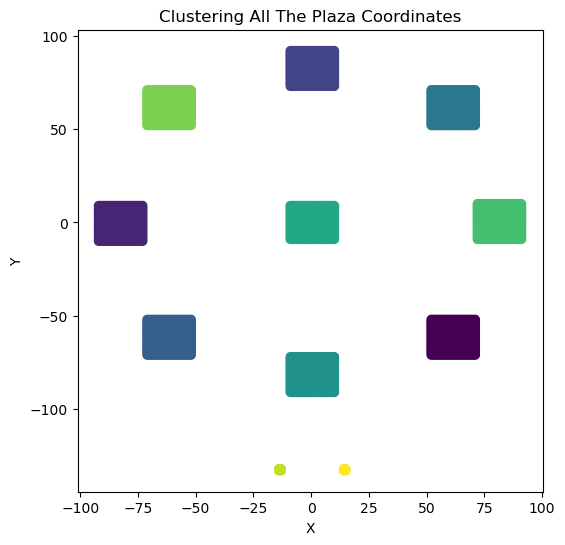

In [64]:
#plot the clustering
plt.figure(figsize=(6,6))
plt.scatter(x, y, c=kmeans.labels_)
plt.title('Clustering All The Plaza Coordinates')
plt.xlabel('X')
plt.ylabel('Y')

In [22]:
#Create mapping dictionary for the labels from clustering to the names of the plazas
mapping_dict = { 0: 'SE Gensis', 1: 'W Genesis', 2:'N Genesis', 3:'SW Genesis', 4:'NE Genesis',
                5:'S Genesis', 6:'C Genesis', 7:'E Genesis', 8:'NW Genesis', 9:'Pixel 1', 10:'Pixel 2'}
mapped_predictions = [ mapping_dict[x] for x in kmeans.labels_]

In [23]:
#Create df with all plaza coordinates and their label
ptswithlblsdf = pd.DataFrame(districtcoord, columns = ['x','y'])
ptswithlblsdf = pd.concat([ptswithlblsdf, pd.DataFrame(mapped_predictions, columns = ["label"])], axis = 1)

In [24]:
#Save the plaza coords info to csv for use in another notebook
ptswithlblsdf.to_csv('DecentralandLandPlazaPts.csv')

In [50]:
#Retrieve road pts from district df
roadpts = districtdf[districtdf['name'] == 'Road']
roadpts
#roadpts.iloc[0,3]

,id,name,description,parcels,totalParcels
21,f77140f9-c7b4-4787-89c9-9fa0e219b079,Road,Decentraland roads connecting districts,"[-99,-29, -94,-29, -93,-29, -90,-29, -89,-29, ...",NaN


In [51]:
#same as plaza, split them out and put all coordinates in df
roadcoord = [[int(x) for x in elt.split(",")] for elt in roadpts.iloc[0,3]]
roadcoord = pd.DataFrame(roadcoord, columns = ['x','y'])
roadcoord

,x,y
0,-99,-29
1,-94,-29
2,-93,-29
3,-90,-29
4,-89,-29
...,...,...
9433,146,-150
9434,147,-150
9435,148,-150
9436,149,-150


In [52]:
#road pts to csv for use in another notebook
roadcoord.to_csv('DecentralandLandRoadPts.csv')

In [26]:
#find each plaza min and max for use to calculate closest plaza and distance
plazasminmax = ptswithlblsdf.groupby('label').agg(xmin = ('x','min'),xmax = ('x','max'),xmean = ('x','mean'),
                                                 ymin = ('y','min'), ymax = ('y','max'), ymean = ('y','mean'))
#plazasminmax

In [27]:
#set up list of list of all points, then use kmeans to predict what plaza closest
allpts = [[i,j] for i in range(-150,151) for j in range(-150,151)]
#len(allpts)
allptspred = kmeans.predict(allpts)
allptspred = [ mapping_dict[x] for x in allptspred]

In [28]:
#put all pts with closest plaza label in df
allptsdf = pd.DataFrame(allpts, columns = ['x','y'])
allptsdf['coord'] = allptsdf.apply(tuple, axis=1)
allptswithlblsdf = pd.concat([allptsdf, pd.DataFrame(allptspred, columns = ["label"])], axis = 1)

Text(0, 0.5, 'Y')

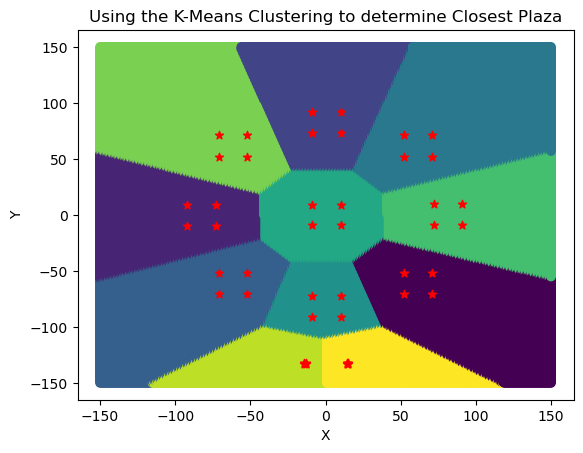

In [59]:
#Show closest plaza on scatterplot
plt.scatter(allptswithlblsdf['x'], allptswithlblsdf['y'], c=kmeans.predict(allpts))
plt.scatter(plazacornerptsdf['x'],plazacornerptsdf['y'],color = 'red', marker = '*')
plt.title('Using the K-Means Clustering to determine Closest Plaza')
plt.xlabel('X')
plt.ylabel('Y')

In [30]:
def findx(row):
    """This function returns the x coordinate. Parcels and Estates have
    this information stored in different columns and need to be merged to one column:
    ------------
    row: This function will be used in a df.apply and each row of the df will sent through
    this function
    return:
    -------
    the x coordinate
    """
    if row['category'] == "parcel":
        return int(row['searchParcelX'])
    else:
        #estates have many coordinate pairs. This grabs the x for 
        #the coordinate that was closest to a plaza
        return int(row['parcels'][row['Plaza Parcel Index']]['x'])
    
def findy(row):
    """This function returns the y coordinate. Parcels and Estates have
    this information stored in different columns and need to be merged to one column:
    ------------
    row: This function will be used in a df.apply and each row of the df will sent through
    this function
    return:
    -------
    the y coordinate
    """
    if row['category'] == "parcel":
        return int(row['searchParcelY'])
    else:
        #estates have many coordinate pairs. This grabs the y for 
        #the coordinates that was closest to a plaza
        return int(row['parcels'][row['Plaza Parcel Index']]['y'])

In [31]:
#remove plazas and road from the districts df
districtdf[districtdf['name'].isin(['Genesis Plaza','Road'])].index
onlydistrictsdf = districtdf.drop(districtdf[districtdf['name'].isin(['Genesis Plaza','Road'])].index,axis = 0)

In [32]:
#give each coordinate pair its own row
onlydistrictsexplodedf = onlydistrictsdf.explode('parcels', ignore_index =True)

#split the coordinate pair column to x and y columns
temp = onlydistrictsexplodedf.apply(lambda x: ([int(i) for i in x['parcels'].split(',')]), axis = 1)
onlydistrictsexplodedxydf = onlydistrictsexplodedf.join(pd.DataFrame(temp.to_list(), columns = ['x','y']))
onlydistrictsexplodedxydf

#find min and max x and y for each district for use in finding cloest district and distance
districtminmax = onlydistrictsexplodedxydf.groupby('name').agg(xmin = ('x','min'),xmax = ('x','max'),
                                                 ymin = ('y','min'), ymax = ('y','max'))

In [33]:
#district pts to csv for use in another notebook
onlydistrictsexplodedxydf.to_csv('DecentralandLandDataDistrictPts.csv')

In [34]:
def FindClosestDistrict(row,ParcelLoc):
    """This function finds the cloest plaza or district and the distance to it
    ------------
    row: This function will be used in a df.apply and each row of the df will sent through
    this function
    ParcelLoc: df with min and max x and y's for either plazas or districts
    return:
    -------
    the a list of the index of the closest plaza/district in df and the distance
    """
    
    #initialize a large distance and a -1 index, and the x and y of the row
    min_dist = 10000
    min_index = -1
    x = row['x']
    y = row['y']
    
    #loop through all plazas/districts
    for index,row in ParcelLoc.iterrows():
        #if x and y are in between xmin, xmax,ymin, and ymax, then parcel is in that 
        #plaza/district. Can return index and distance of 0
        if (x >= row['xmin'] and x <= row['xmax'] and y >= row['ymin'] and y <= row['ymax']):
            return [index, 0]
        #if x is in between xmin and xmax, the distance will be minimum of
        # y-ymin and y-ymax
        elif (x >= row['xmin'] and x <= row['xmax']):
            temp_dist = min(abs(y-row['ymin']),abs(y-row['ymax']))
        ##if y is in between ymin and ymax, the distance will be minimum of
        # x-xmin and x-xmax
        elif (y >= row['ymin'] and y <= row['ymax']):
            temp_dist = min(abs(x-row['xmin']),abs(x-row['xmax']))
        #otherwise it is the min of any of the options
        else:
            temp_dist = max(min(abs(x-row['xmin']),abs(x-row['xmax'])),min(abs(y-row['ymin']),abs(y-row['ymax'])))
        
        #if the dist is less than current min dist, then make it new min dist and index
        if temp_dist < min_dist:
            min_dist = temp_dist
            min_index = index
    
    return [min_index, min_dist]

In [35]:
allptswithfunlblsdf = allptsdf
#allptswithfunlblsdf

In [36]:
#Check how long to run
start = time.time()

#find closest plazas and districts and distances
allptswithfunlblsdf[['Closest Plaza','Dist to Plaza']] = allptswithfunlblsdf.apply(FindClosestDistrict, ParcelLoc = plazasminmax, axis = 1, result_type = 'expand')
allptswithfunlblsdf[['Closest District','Dist to District']] = allptswithfunlblsdf.apply(FindClosestDistrict,ParcelLoc = districtminmax, axis = 1, result_type = 'expand')

end = time.time()
print(end-start)

#set index as coordinates to then make a dictionary
allptswithfunlblsindexdf = allptswithfunlblsdf.set_index("coord")
allptswithfunlblsindexdf

302.4902722835541


,x,y,Closest Plaza,Dist to Plaza,Closest District,Dist to District
coord,,,,,,
"(-150, -150)",-150,-150,SW Genesis,79.0,Fashion Street,131
"(-150, -149)",-150,-149,SW Genesis,79.0,Fashion Street,130
"(-150, -148)",-150,-148,SW Genesis,79.0,Fashion Street,129
"(-150, -147)",-150,-147,SW Genesis,79.0,Fashion Street,128
"(-150, -146)",-150,-146,SW Genesis,79.0,Fashion Street,127
...,...,...,...,...,...,...
"(150, 146)",150,146,NE Genesis,79.0,Aetheria,0
"(150, 147)",150,147,NE Genesis,79.0,Aetheria,0
"(150, 148)",150,148,NE Genesis,79.0,Aetheria,0


In [37]:
#make dictionary so the sales can look up the distance for their coordinates
allptsdict = allptswithfunlblsindexdf.to_dict('index')

In [38]:
#opposite of the previous mapping dict. plaza name to numeric
oppo_mapping_dict = { 'SE Gensis':0, 'W Genesis':1, 'N Genesis':2, 'SW Genesis':3, 'NE Genesis':4,
                     'S Genesis':5, 'C Genesis':6, 'E Genesis':7, 'NW Genesis':8, 'Pixel 1':9, 'Pixel 2':10}
numeral_plaza = [ oppo_mapping_dict[x] for x in allptswithfunlblsdf['Closest Plaza']]
#numeral_plaza

In [39]:
#make list of list of all plaza corner points
plazacornerpts = []
for index,row in plazasminmax.iterrows():
    plazacornerpts.append([row['xmin'],row['ymin']])
    plazacornerpts.append([row['xmin'],row['ymax']])
    plazacornerpts.append([row['xmax'],row['ymin']])
    plazacornerpts.append([row['xmax'],row['ymax']])

plazacornerptsdf = pd.DataFrame(plazacornerpts, columns=['x','y'])


Text(0, 0.5, 'Y')

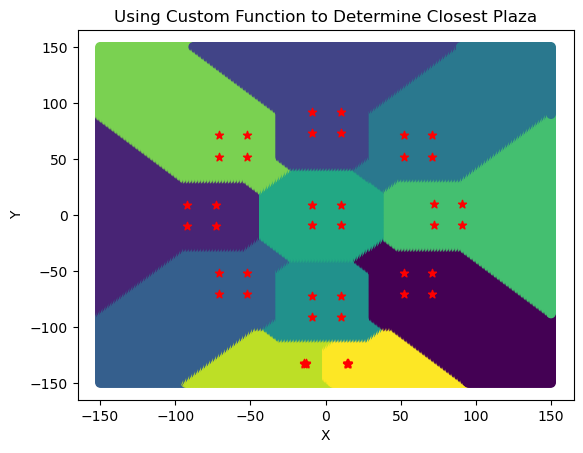

In [62]:
#make scatterplot of the calculated closest plaza 
plt.scatter(allptswithlblsdf['x'], allptswithlblsdf['y'], c=numeral_plaza)
plt.scatter(plazacornerptsdf['x'],plazacornerptsdf['y'],color = 'red', marker = '*')
plt.title('Using Custom Function to Determine Closest Plaza')
plt.xlabel('X')
plt.ylabel('Y')

In [41]:
def FindClosestForSales(row,landtype):
    """This function finds the closest plaza or district and the distance for each sale
    It uses the previously made dictionary to look up thhe sales coords
    ------------
    row: This function will be used in a df.apply and each row of the df will sent through
    this function
    landtype: string for either Plaza or District
    return:
    -------
    the a list of the the closest plaza/district, the minimum distance, and the index of the
    coordinates (only matters if it is an estate)
    """
    #if parcel, only one coordinate pair to check
    if row['category'] == 'parcel':
        xycoord = (int(row['searchParcelX']),int(row['searchParcelY']))
        return [allptsdict[xycoord]['Closest ' + str(landtype)],allptsdict[xycoord]['Dist to ' + str(landtype)],-1]
    #an estate, need to check every coordinate pair
    #really just need to check the edges, but would take time to figure out
    #what are the edges, so checking all
    else:
        min_dist = 10000
        min_plaza = ''
        min_index = -1
        
        #loop through all coord pairs. If smaller than min, set as min for all variables
        for i in range(len(row['parcels'])):
            xycoord = (int(row['parcels'][i]['x']),int(row['parcels'][i]['y']))
            if allptsdict[xycoord]['Dist to ' + str(landtype)] < min_dist:
                min_dist = allptsdict[xycoord]['Dist to ' + str(landtype)]
                min_plaza = allptsdict[xycoord]['Closest ' + str(landtype)]
                min_index = i
        return [min_plaza,min_dist,min_index]

In [42]:
#Use above function to find closest plaza and district and distances for each sale
dfS[['Closest Plaza','Dist to Plaza','Plaza Parcel Index']] = dfS.apply(FindClosestForSales, landtype = "Plaza", axis = 1, result_type = 'expand')
dfS[['Closest District','Dist to District','District Parcel Index']] = dfS.apply(FindClosestForSales, landtype = "District", axis = 1, result_type = 'expand')

In [43]:
#find the x and y coordinates used for the closest plaza for each sale
dfS['X'] = dfS.apply(findx, axis=1)
dfS['Y'] = dfS.apply(findy, axis=1)

#drop columns that don't need anymore
dfS.drop(["searchParcelX","searchParcelY","parcels","Plaza Parcel Index","District Parcel Index"], axis = 1,inplace = True)
dfS

,id,sale price (MANA),timestamp,type,category,Estate Size,Date,adjacentRoadCount,MANA price (USD),ETH price (USD),sale price (USD),Closest Plaza,Dist to Plaza,Closest District,Dist to District,X,Y
0,1,100000.0,1539280016,order,estate,2,2018-10-11,0.0,0.074934,225.662016,7493.396964,SW Genesis,36.0,Fashion Street,88,-100,-107
1,2,100000.0,1539280356,order,estate,2,2018-10-11,0.0,0.074934,225.662016,7493.396964,SW Genesis,36.0,Fashion Street,88,-100,-107
2,3,32000.0,1539287969,order,parcel,1,2018-10-11,0.0,0.074934,225.662016,2397.887029,N Genesis,61.0,Vegas City,4,-70,145
3,4,30000.0,1539329807,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,2039.081627,C Genesis,18.0,Bittrex Tomorrow,29,-27,-21
4,5,15000.0,1539334568,order,parcel,1,2018-10-12,0.0,0.067969,192.001084,1019.540813,E Genesis,19.0,Dragon City,11,65,-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13402,24998,6500.0,1682370995,bid,parcel,1,2023-04-24,1.0,0.561967,1863.639142,3652.787235,C Genesis,21.0,Bittrex Tomorrow,26,-30,4
13403,24999,4100.0,1682377067,order,estate,2,2023-04-24,0.0,0.561967,1863.639142,2304.065794,SW Genesis,55.0,Fashion Street,63,-126,-82
13404,25000,2185.0,1682445635,order,parcel,1,2023-04-25,0.0,0.556188,1842.630792,1215.269853,W Genesis,12.0,Star City,3,-61,-12
13405,25001,5000.0,1682567387,bid,estate,4,2023-04-27,0.0,0.542875,1867.589325,2714.373820,NE Genesis,32.0,Voltaire,5,45,103


In [44]:
#save df to csv for use in another notebook
dfS.to_csv('DecentralandLandDataFinal.csv')